**STEP 1: IMPORT ALL THE NECESSARY PYTHON LIBRARIES/MODULES FOR THE CODE IMPLEMENTATION**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
import joblib
import warnings
warnings.filterwarnings("ignore")

**STEP 2: LOAD AND EXPLORE THE DATA**

Dataset shape: (284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-n

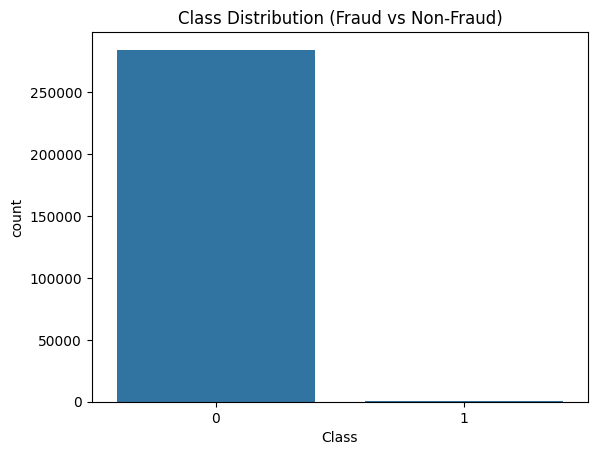

In [ ]:
# Load dataset
df = pd.read_csv('/content/creditcard.csv')

# Basic info about the dataset
print("Dataset shape:", df.shape)
print(df.info())
print(df.describe())
print(df.head())

# Checking for class distribution
print("\nClass Distribution:\n", df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.show()

**STEP 3: PERFORMING EXPLORATORY DATA ANALYSIS [EDA]**

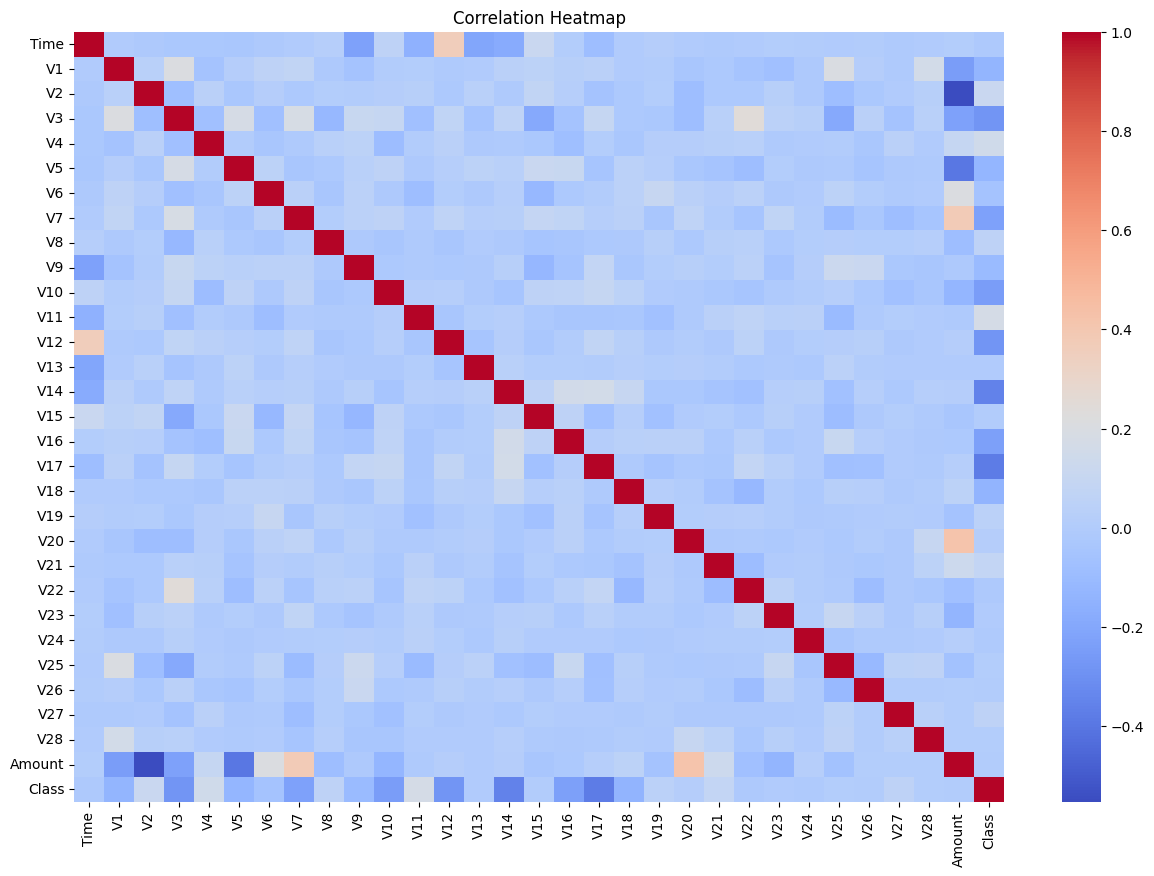

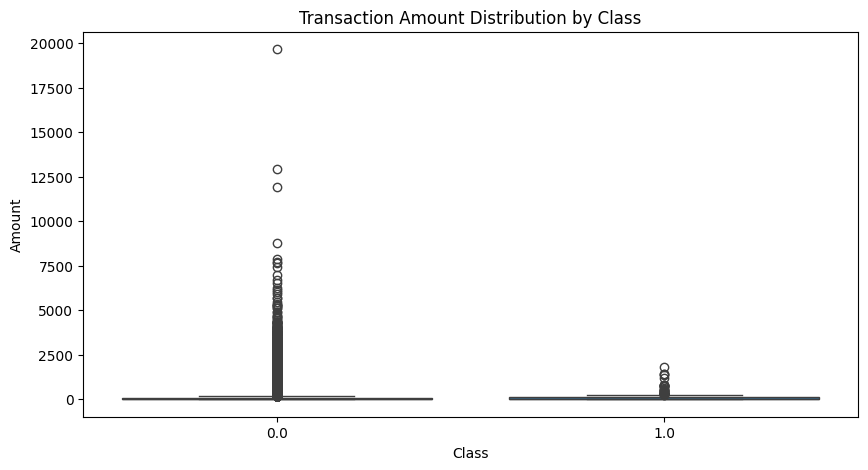

In [ ]:
# Correlation heatmap to identify relationships between features
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Distribution of 'Amount' feature for fraud and non-fraud transactions
plt.figure(figsize=(10,5))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Transaction Amount Distribution by Class")
plt.show()

**STEP 4:DATA PREPROCESSING AND FEATURE SCALING**

Standardize the 'Amount' Feature and Drop the 'Time' Feature

In [ ]:
# Standardize 'Amount' column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Drop 'Time' column if it exists
if 'Time' in df.columns:
    df.drop(['Time'], axis=1, inplace=True)

In [ ]:
# Separate fraud and non-fraud classes
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

# Downsample the majority class to match the minority class
non_fraud_downsampled = non_fraud.sample(n=len(fraud), random_state=42)
df_balanced = pd.concat([fraud, non_fraud_downsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print("Balanced Class Distribution:\n", df_balanced['Class'].value_counts())

Balanced Class Distribution:
 Class
1.0    259
0.0    259
Name: count, dtype: int64


**STEP 5: TRAIN-TEST SPLIT**

In [ ]:
# Separate features and target variable
X = df_balanced.drop('Class', axis=1)
y = df_balanced['Class']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**STEP 6: DEFINE AND COMPARE MULTIPLE MODELS WITH CROSS-VALIDATION**

In [ ]:
# Define models for comparison
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Support Vector Classifier': SVC(kernel='linear', probability=True)
}

# Cross-validation function to evaluate each model
def evaluate_model(model, X_train, y_train):
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f"{model.__class__.__name__} - Mean ROC AUC: {scores.mean():.4f} | Std: {scores.std():.4f}")
    return scores.mean()

# Evaluate each model and store results
model_scores = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    model_scores[model_name] = evaluate_model(model, X_train, y_train)


Evaluating Logistic Regression...
LogisticRegression - Mean ROC AUC: 0.9703 | Std: 0.0077

Evaluating Random Forest...
RandomForestClassifier - Mean ROC AUC: 0.9755 | Std: 0.0083

Evaluating Gradient Boosting...
GradientBoostingClassifier - Mean ROC AUC: 0.9665 | Std: 0.0155

Evaluating Decision Tree...
DecisionTreeClassifier - Mean ROC AUC: 0.8961 | Std: 0.0164

Evaluating AdaBoost...
AdaBoostClassifier - Mean ROC AUC: 0.9529 | Std: 0.0156

Evaluating Support Vector Classifier...
SVC - Mean ROC AUC: 0.9714 | Std: 0.0079


**STEP 7: HYPERPARAMETER TUNING FOR THE RANDOM FOREST MODEL**

In [ ]:
# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
rf_model = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf = grid_search.best_estimator_
print("\nBest Random Forest Parameters:", grid_search.best_params_)
print("Best Random Forest Mean ROC AUC:", grid_search.best_score_)


Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Mean ROC AUC: 0.9792385484830458


**STEP 8: MODEL EVALUATION ON TEST DATA AND CONFUSION MATRIX**


Confusion Matrix:


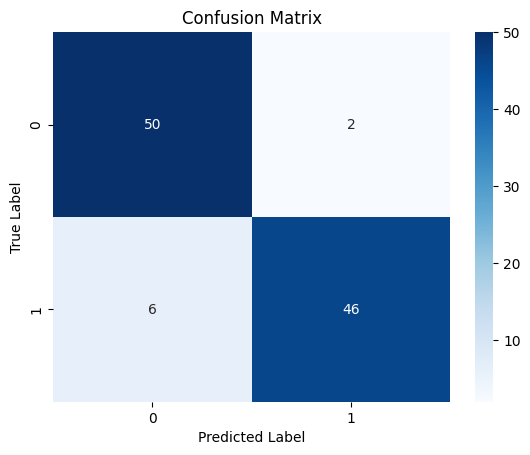


Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93        52
         1.0       0.96      0.88      0.92        52

    accuracy                           0.92       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.93      0.92      0.92       104


ROC AUC Score: 0.963757396449704


In [ ]:
# Evaluate the best model on test data
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

**STEP 9: PRECISION RECALL CURVE AND ROC CURVE**

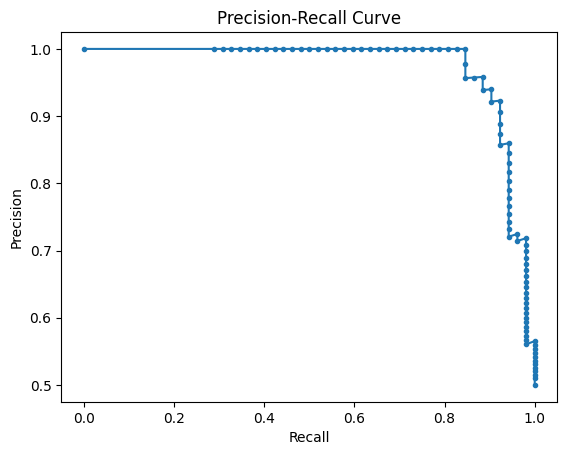

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

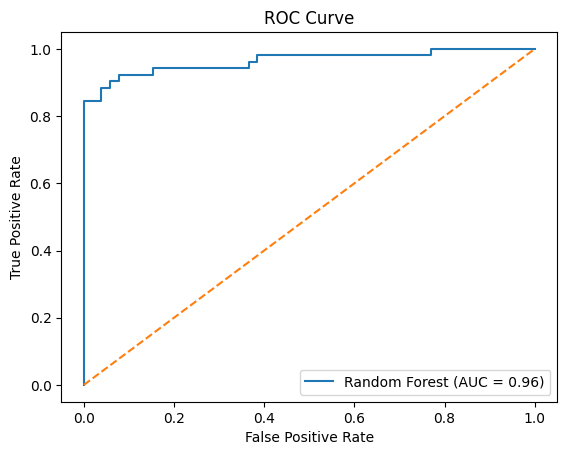

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

**STEP 10: MODEL COMPARISION SUMMARY**

In [ ]:
# Print a summary of the model performances
print("\nModel Comparison Summary (Mean ROC AUC Scores):")
for model_name, score in model_scores.items():
    print(f"{model_name}: {score:.4f}")


Model Comparison Summary (Mean ROC AUC Scores):
Logistic Regression: 0.9703
Random Forest: 0.9755
Gradient Boosting: 0.9665
Decision Tree: 0.8961
AdaBoost: 0.9529
Support Vector Classifier: 0.9714


**STEP 11: SAVE THE BEST MODEL**

In [ ]:
# Save the best model to disk
joblib.dump(best_rf, 'best_random_forest_model.pkl')
print("\nBest model saved as 'best_random_forest_model.pkl'")


Best model saved as 'best_random_forest_model.pkl'


**STEP 12: LOAD AMD PREDICT USING THE SAVED MODEL**

In [ ]:
# Load the saved model
loaded_model = joblib.load('best_random_forest_model.pkl')

# Predict on a new sample or test data
sample_data = X_test.iloc[:1]  # example of taking one sample from the test set
sample_prediction = loaded_model.predict(sample_data)
sample_prediction_proba = loaded_model.predict_proba(sample_data)

print("\nSample Prediction:", sample_prediction)
print("Sample Prediction Probability:", sample_prediction_proba)


Sample Prediction: [0.]
Sample Prediction Probability: [[0.61044639 0.38955361]]


**STEP 13: FEATURE IMPORTANCE VISUALIZATION**

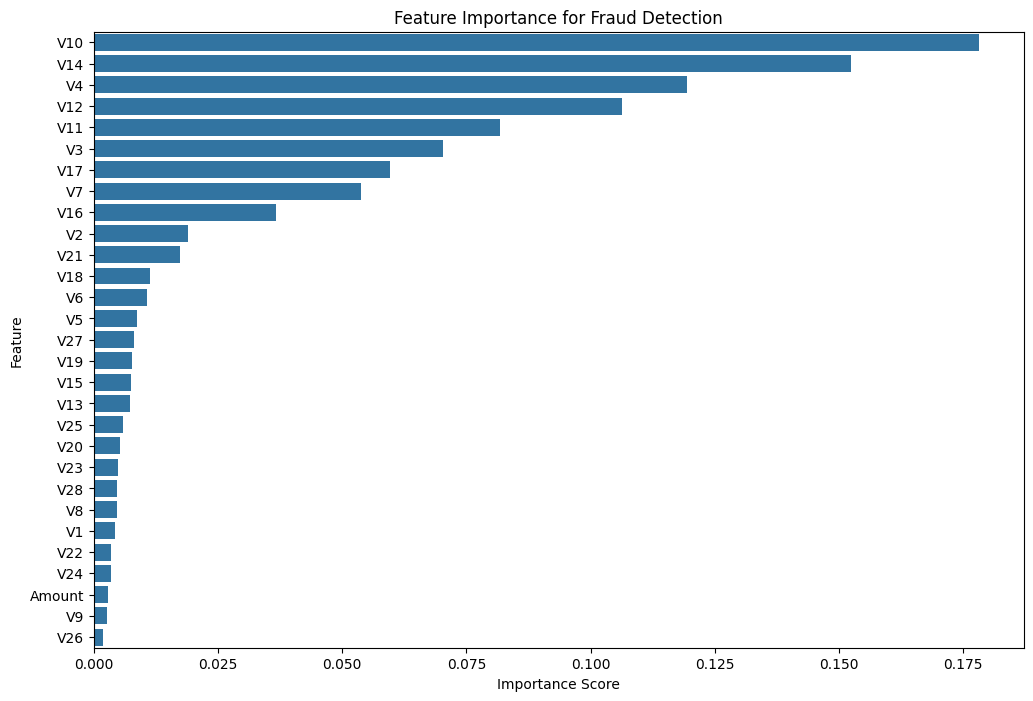

In [ ]:
# Feature importance from the best Random Forest model
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Feature Importance for Fraud Detection")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

**VISUALIZE FRAUD V/S NON-FRAUD TRANSACTIONS IN KEY FEATURES**

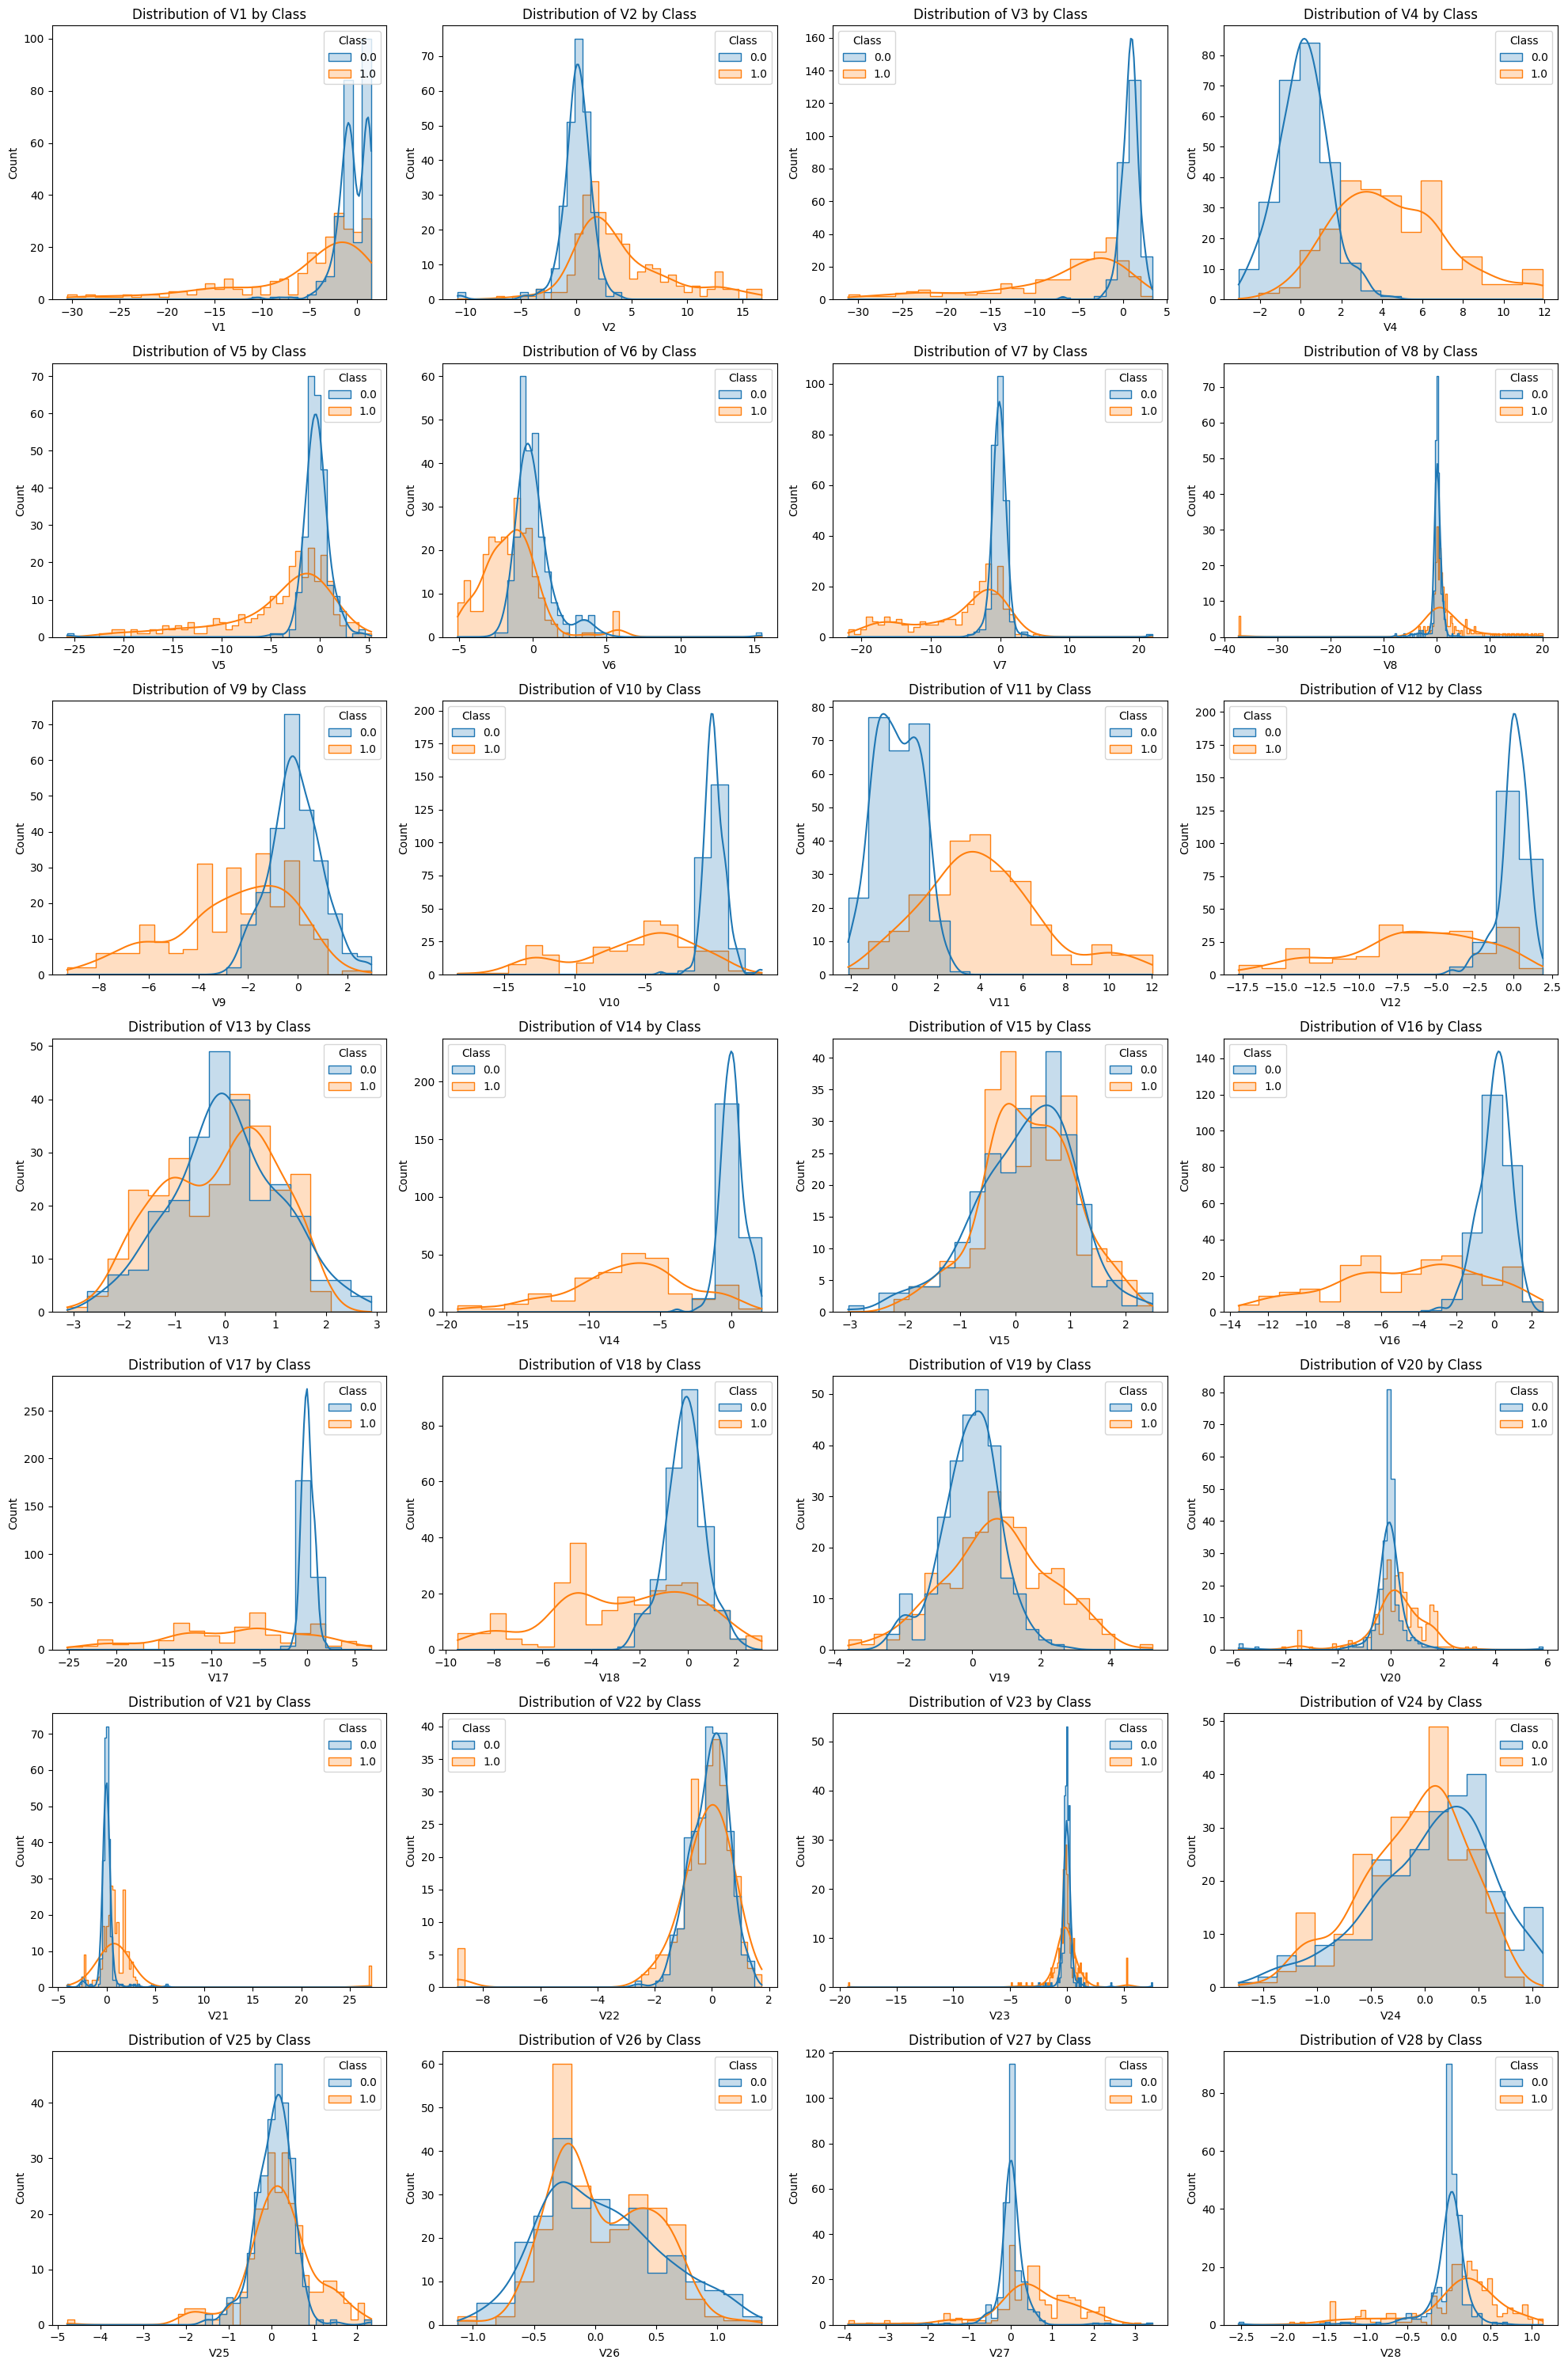

In [ ]:
# Create subplots for each feature V1 to V28
num_features = 28
rows = 7
cols = 4
plt.figure(figsize=(20, 30))

for i in range(1, num_features + 1):
    plt.subplot(rows, cols, i)
    feature_name = f"V{i}"
    sns.histplot(data=df_balanced, x=feature_name, hue='Class', kde=True, element='step')
    plt.title(f"Distribution of {feature_name} by Class")
    plt.xlabel(feature_name)

plt.tight_layout()
plt.show()

**STEP 15: PAIR PLOT FOR THE MAIN FEATURES**

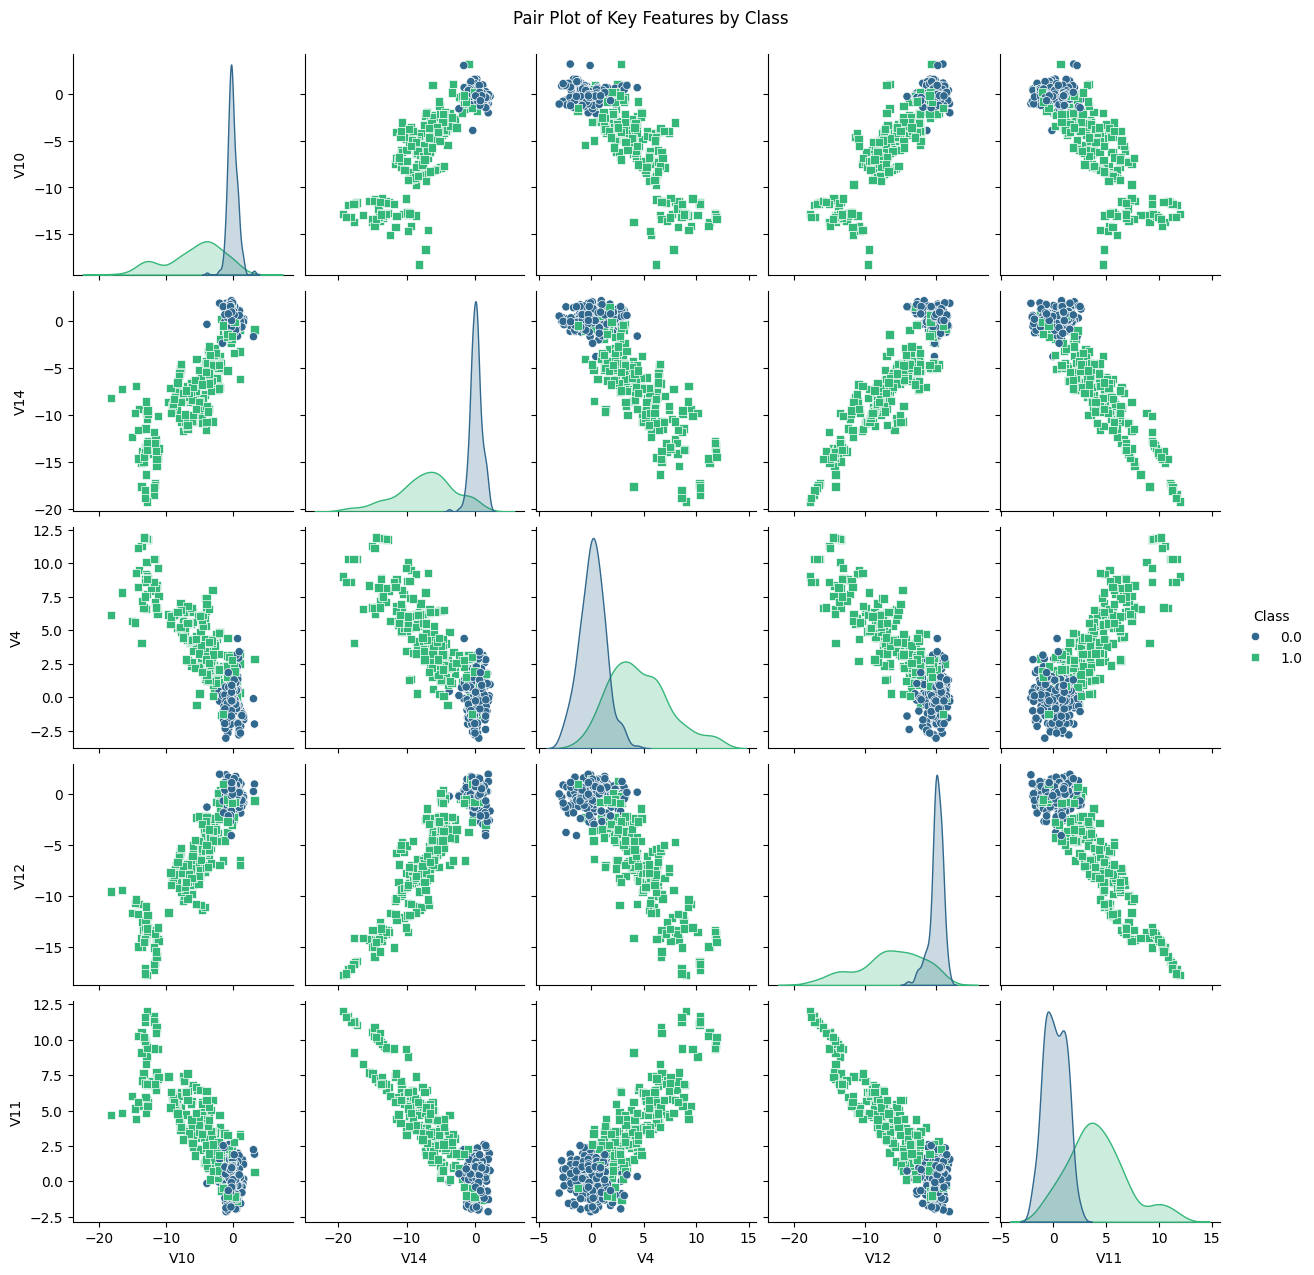

In [ ]:
# Pair plot for top features by importance
sns.pairplot(df_balanced, vars=key_features, hue="Class", palette="viridis", diag_kind="kde", markers=["o", "s"])
plt.suptitle("Pair Plot of Key Features by Class", y=1.02)
plt.show()

**STEP 16: VISUALIZING FEAUD VS NON-FRAUD TRANSACTIONS USING PRINCIPAL COMPONENT ANALYSIS [PCA]**

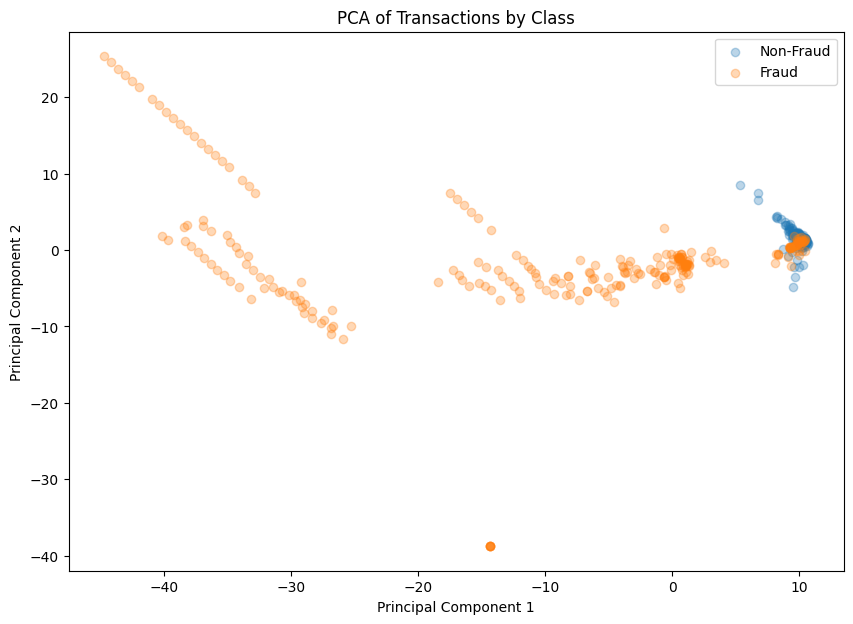

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot PCA components for fraud vs. non-fraud
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Non-Fraud', alpha=0.3)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='Fraud', alpha=0.3)
plt.title("PCA of Transactions by Class")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

**STEP 17: CONFUSION MATRIX WITH ADDITIONAL POSSIBLE METRICS**

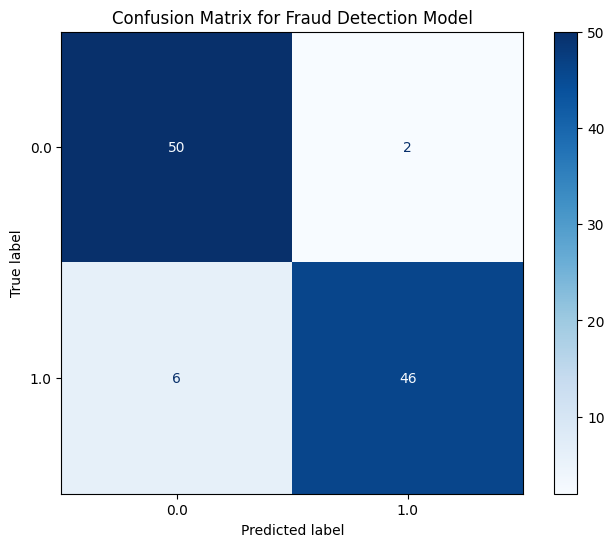


Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93        52
         1.0       0.96      0.88      0.92        52

    accuracy                           0.92       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.93      0.92      0.92       104



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix with labels
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Fraud Detection Model")
plt.show()

# Display detailed metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

**STEP 18: PRECISION RECALL CURVES FOR MULTIPLE MODELS**

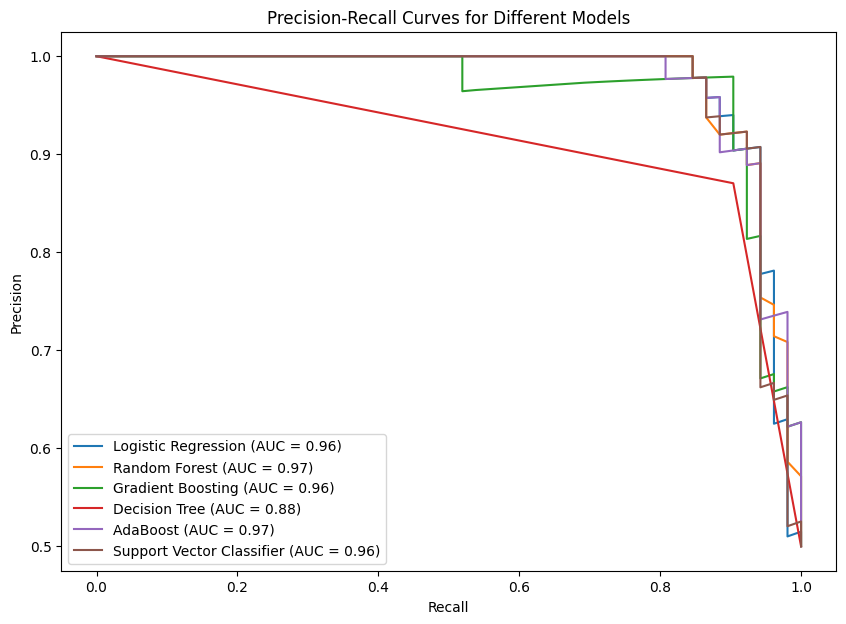

In [ ]:
# Function to plot Precision-Recall curves
def plot_precision_recall(models, X_train, y_train, X_test, y_test): # Added X_train, y_train
    plt.figure(figsize=(10, 7))
    for name, model in models.items():
        # Fit the model if it's not already fitted
        if not hasattr(model, "classes_"):  # Check if the model is fitted by checking for 'classes_' attribute
            model.fit(X_train, y_train)     # Fit the model using training data
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.plot(recall, precision, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves for Different Models")
    plt.legend(loc="best")
    plt.show()

# Assuming X_train and y_train are your training data
# Plot for multiple models, passing training data for fitting
plot_precision_recall(models, X_train, y_train, X_test, y_test) # Pass X_train, y_train to the function

**STEP 19: VISUALIZE ROC CURVES FOR ALL MODELS**

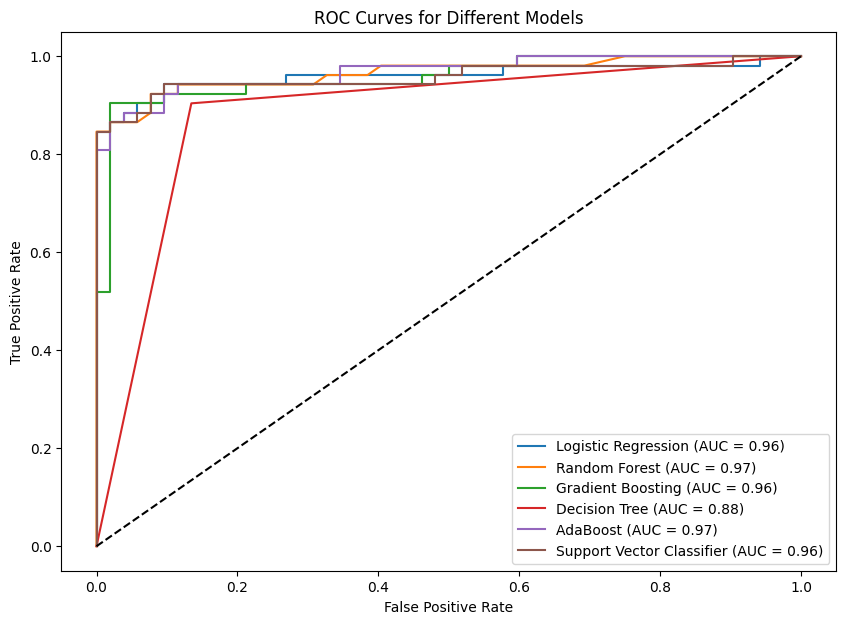

In [ ]:
# Function to plot ROC curves
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 7))
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Different Models")
    plt.legend(loc="best")
    plt.show()

# Plot for multiple models
plot_roc_curves(models, X_test, y_test)

**STEP 20: TIME SERIES ANALYSIS OF FRAUD TRANSACTIONS**

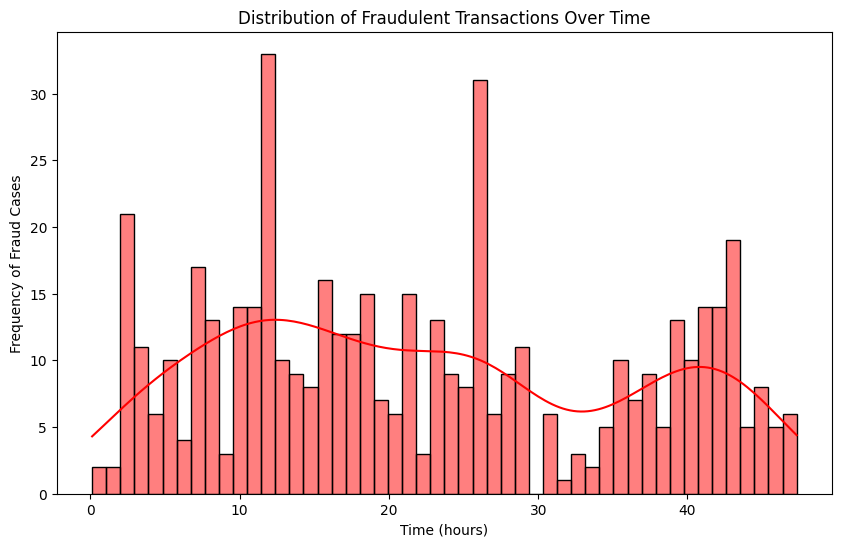

In [ ]:
# Ensure 'Time' feature is included if needed
if 'Time' in df.columns:
    df['Time'] = df['Time'] / 3600  # convert seconds to hours
    fraud_cases = df[df['Class'] == 1]

    plt.figure(figsize=(10, 6))
    sns.histplot(fraud_cases['Time'], bins=50, kde=True, color='red')
    plt.title("Distribution of Fraudulent Transactions Over Time")
    plt.xlabel("Time (hours)")
    plt.ylabel("Frequency of Fraud Cases")
    plt.show()

**STEP 21: SUMMARY OF MODEL PERFORMANCES WITH A BAR CHART**

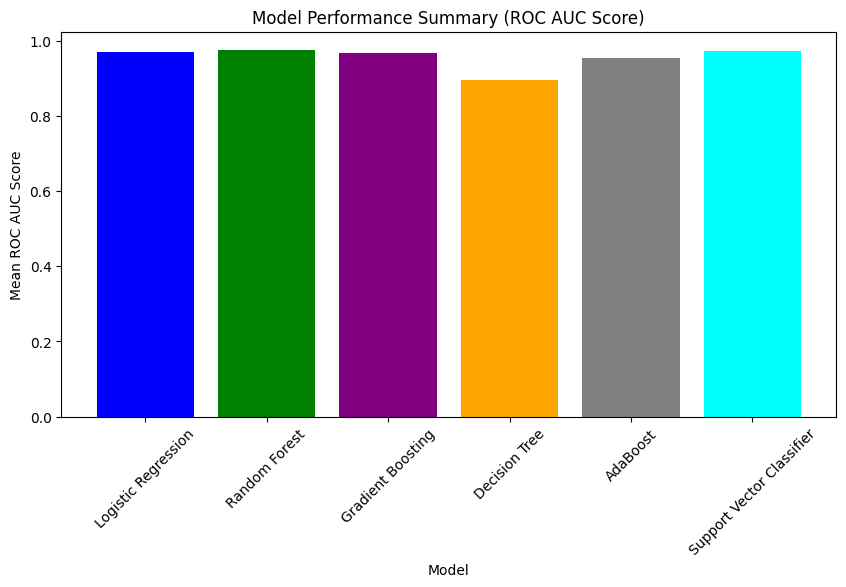

In [ ]:
# Plotting model performance summary
plt.figure(figsize=(10, 5))
plt.bar(model_scores.keys(), model_scores.values(), color=['blue', 'green', 'purple', 'orange', 'grey', 'cyan'])
plt.xlabel("Model")
plt.ylabel("Mean ROC AUC Score")
plt.title("Model Performance Summary (ROC AUC Score)")
plt.xticks(rotation=45)
plt.show()

**STEP 22: SAVE MODEL PERFORMANCE METRICS FOR FURTHER ANALYSIS AND COMPUTATION**

In [ ]:
# Create a DataFrame to save model scores
model_performance_df = pd.DataFrame.from_dict(model_scores, orient='index', columns=['ROC AUC Score']).reset_index()
model_performance_df.rename(columns={'index': 'Model'}, inplace=True)

# Save to CSV
model_performance_df.to_csv("model_performance_summary.csv", index=False)
print("Model performance summary saved to 'model_performance_summary.csv'")

Model performance summary saved to 'model_performance_summary.csv'


#**EXPLAINABILITY USING LIME eXPlainable AI MODEL**

**STEP 23: INSTALL AND IMPORT LIME EXPLAINABLE AI MODEL FOR EXPLAINABILITY**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fa2cd87f6365467bd805c59ba0d486ec44958833aad7ab2ea26cccc3e3abad99
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

# Assuming 'best_rf' is your trained Random Forest model
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Non-Fraud', 'Fraud'],
    mode='classification'
)

# Explain an instance from the test set
i = 0  # Choose an instance to explain
explanation = explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=best_rf.predict_proba,
    num_features=10  # Number of features to show in the explanation
)

# Display the explanation
explanation.show_in_notebook(show_table=True)

**STEP 24: CHOOSE AN INSTANCE TO VISUALIZE AND EXPLAIN**

In [ ]:
# Select an instance from the test set
instance_idx = 0
instance = X_test.iloc[instance_idx]

In [ ]:
# Generate explanation for the selected instance
explanation = explainer.explain_instance(
    data_row=instance.values,
    predict_fn=best_rf.predict_proba  # Use the predict_proba method for probability output
)

In [ ]:
explanation

In [ ]:
# Display the explanation in notebook format
explanation.show_in_notebook(show_table=True)

**STEP 25: LIME MODEL EXPLANATION SUMMARY PLOT**

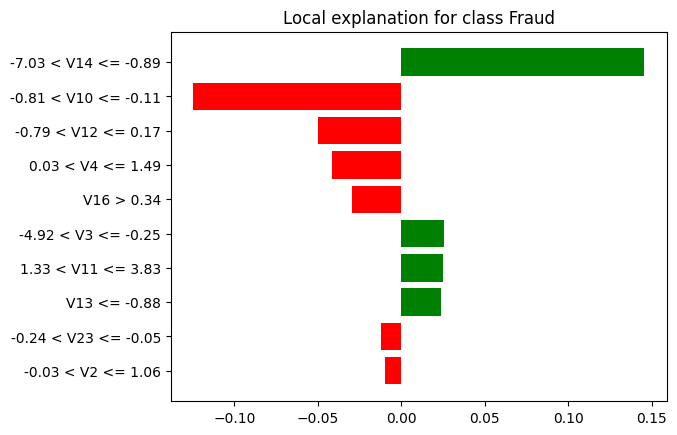

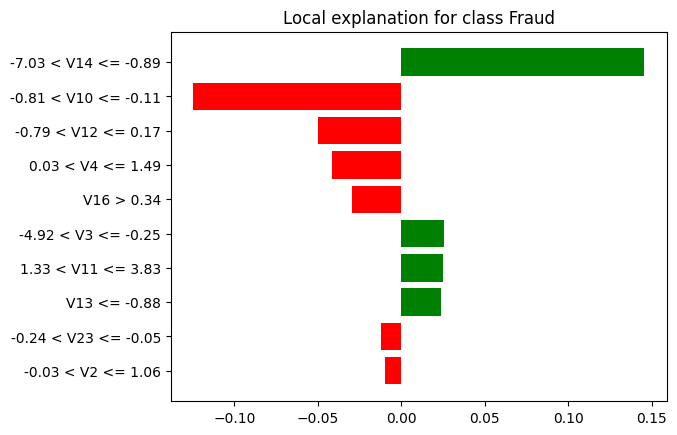

In [ ]:
# Plot the LIME explanation for visual analysis
explanation.as_pyplot_figure()

**STEP 26: SAVE LIME EXPLANATION FOR FUTURE REFERENCE**

In [ ]:
# Save the explanation to an HTML file
explanation.save_to_file("lime_explanation.html")

In [ ]:
# Generate explanations for a set of instances
for i in range(3):
    instance = X_test.iloc[i]
    explanation = explainer.explain_instance(instance.values, best_rf.predict_proba)
    explanation.show_in_notebook(show_table=True)

**STEP 27: SAVE MULTIPLE EXPLANATIONS**

In [ ]:
# Save explanations for each instance
for i in range(3):
    instance = X_test.iloc[i]
    explanation = explainer.explain_instance(instance.values, best_rf.predict_proba)
    explanation.save_to_file(f"lime_explanation_instance_{i}.html")

**STEP 28: MATTHEWS CORRELATION COEFFICIENT (MCC) AND OTHER EVALUATION METRICS LIKE Specificity, Balanced Accuracy, False Positive Rate (FPR), False Negative Rate (FNR), Log Loss, F2 Score, Sensitivity (True Positive Rate), and G-Mean**

In [ ]:
# Predicting class labels on the test set
y_pred_rf = best_rf.predict(X_test)
# Predicting class probabilities on the test set
y_pred_proba_rf = best_rf.predict_proba(X_test)

In [ ]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, balanced_accuracy_score, log_loss, fbeta_score
import numpy as np

# Assuming y_test and y_pred_rf are already defined, and y_pred_proba_rf contains the predicted probabilities
# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred_rf)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()

# Calculate Specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

# Calculate Balanced Accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba_rf)
print(f"Log Loss: {logloss:.4f}")

# Calculate F2 Score (beta=2)
f2_score = fbeta_score(y_test, y_pred_rf, beta=2)
print(f"F2 Score: {f2_score:.4f}")

# Calculate Sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")

# Calculate G-Mean
g_mean = np.sqrt(sensitivity * specificity)
print(f"G-Mean: {g_mean:.4f}")

Matthews Correlation Coefficient (MCC): 0.8487
Specificity: 0.9615
Balanced Accuracy: 0.9231
False Positive Rate (FPR): 0.0385
False Negative Rate (FNR): 0.1154
Log Loss: 0.2111
F2 Score: 0.8984
Sensitivity (True Positive Rate): 0.8846
G-Mean: 0.9223


In [ ]:
# Assuming you want to find the key features based on feature importance
key_features = feature_importances[:10].index.tolist()
key_features

['V10', 'V14', 'V4', 'V12', 'V11', 'V3', 'V17', 'V7', 'V16', 'V2']